# **Методы оптимизации в машинном и глубоком обучении. От простого к сложному**

В данном туториале представлен обзор различных популярных (и не только) оптимизаторов, которые применяются в машинном и глубоком обучении, в частности для обучения нейронных сетей. Мы рассмотрим их основную идею и ключевые особенности, переходя от простых к более сложным концепциям. Помимо этого, в самом конце вы сможете найти большое количество дополнительных источников для более детального ознакомления с материалом.


## **Пару слов про функции потерь**

Функции потерь можно разделить на выпуклые и невыпуклые. Первый вариант чаще всего встречается в классическом машинном обучении из-за относительной простоты моделей, а также из-за того, что у выпуклых функций локальный минимум по определению является и глобальным (но не обязательно единственным). Невыпуклые функции, в свою очередь, чаще всего встречаются в нейронных сетях из-за их высокой сложности и в данном случае поиск глобального минимума является трудной задачей, поэтому на практике здесь также используются методы из случая с выпуклыми функциями из-за их способности хорошо аппроксимировать стационарные точки в невыпуклом случае. Проще говоря, методы для выпуклого случая могут хорошо сходиться в локальном оптимуме для невыпуклого случая за приемлемое время, значение которого близко к глобальному.

## **Классический градиентный спуск**

Начнём с того, что если градиент — это вектор наибыстрейшего возрастания функции, то антиградиент — вектор наибыстрейшего убывания, и именно при движении в данную сторону будет расположена минимальная ошибка модели. Тогда градиентный спуск можно определить как численный метод итеративной оптимизации для нахождения весов (коэффициентов) модели путём минимизации её ошибки, представленной в виде функции потерь. Пример работы данного алгоритма на линейной и логистической регрессий с нуля можно посмотреть [здесь](https://habr.com/ru/articles/804135/) и [здесь](https://habr.com/ru/articles/803397/).

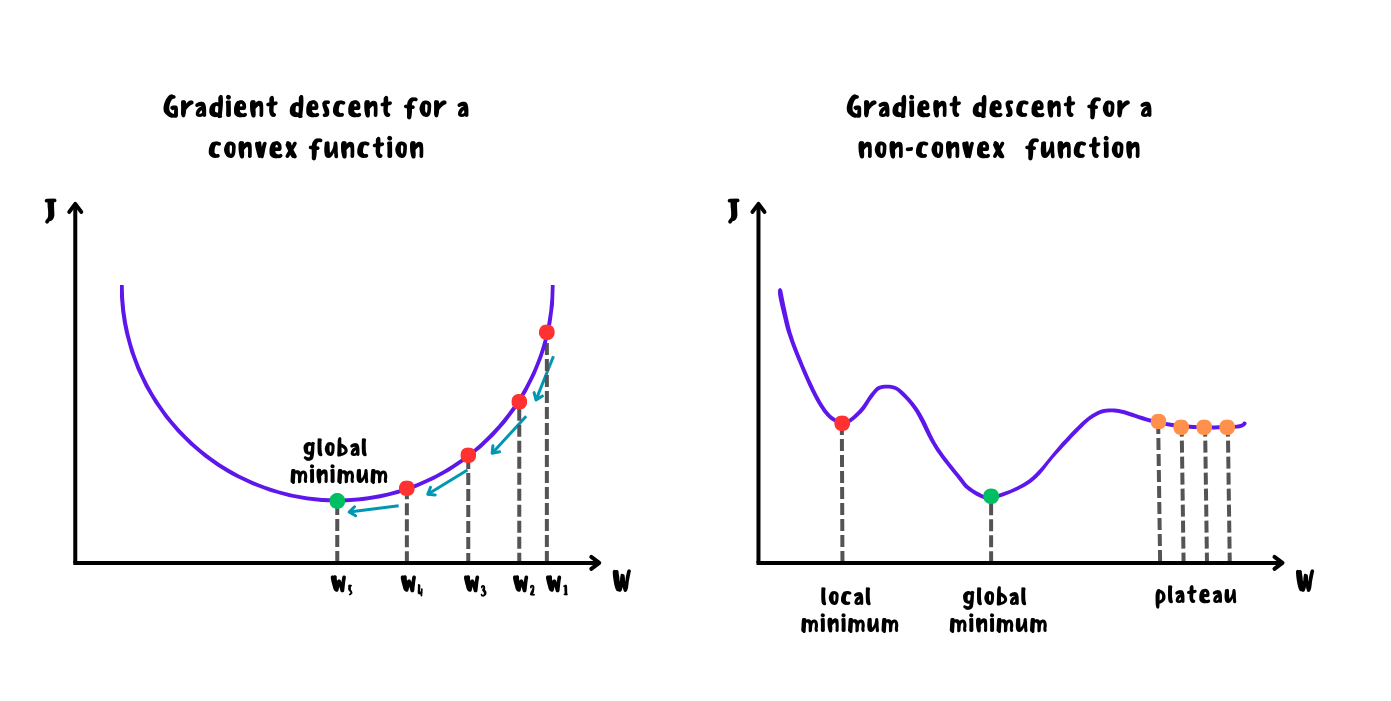

**Алгоритм строится следующим образом:**
- 1) изначально происходит инициализация весов с нулевыми значениями;
- 2) далее на основе установленных весов модель делает прогноз;
- 3) на основе полученного прогноза рассчитывается градиент ошибки, после чего происходит обновление весов в сторону антиградиента функции потерь;
- 4) шаги 2-3 повторяются до тех пор, пока градиент не станет нулевым, то есть пока алгоритм не сойдётся в минимуме (как правило, в данном случае используется критерий останова, например, пока разность градиентов на текущей и предыдущей итерациях не станет меньше заранее установленного порогового значения).

Если для вычисления градиентов функции потерь используется полный обучающий набор, то такой градиентный спуск называется **пакетным**. Не смотря на то, что пакетный градиентный спуск (batch gradient descent) практически всегда хорошо масштабируется в отношении количества признаков, данный алгоритм работает очень медленно на больших наборах данных и требует значительных затрат в виде дополнительной памяти для хранения всех градиентов.

Для увеличения производительности на больших датасетах применяются 2 подхода:
- 1) **Мини-пакетный** градиентный спуск (mini-batch gradient descent), когда на каждом шаге вычисление градиентов происходит на небольших случайных поднаборах (мини-пакетах). Обычно размер мини-пакета берётся в виде $2^n$ и может достигать нескольких десятков тысяч образцов: выбор размера зависит от особенностей задачи и применяемой модели.

- 2) **Стохастический** градиентный спуск (stochastic gradient descent), когда на каждом шаге из обучающего набора берётся лишь один образец. Очевидно, что такой вариант должен работать гораздо быстрее предыдущего, но с другой стороны, из-за ещё более стохастический природы данный алгоритм менее стабилен и может потребоваться больше итераций для сходимости, а также mini-batch дает прирост в производительности из-за аппаратной оптимизации матричных вычислений на GPU. Стоит также отметить, что на данный момент под стохастическим градиентный спуском очень часто подразумевается mini-batch.

В отличие от пакетного градиентного спуска, в данных случаях функция потерь будет снижаться скачками вверх-вниз, приближаясь к минимуму, но так и не достигнув его. В случае с мини-пакетным градиентным спуском функция потерь будет расположена чуть ближе к минимуму за счёт меньшего размера скачков. С другой стороны, в отличие от стохастического градиентного спуска, ему может быть труднее пройти локальные минимумы в невыпуклом случае.


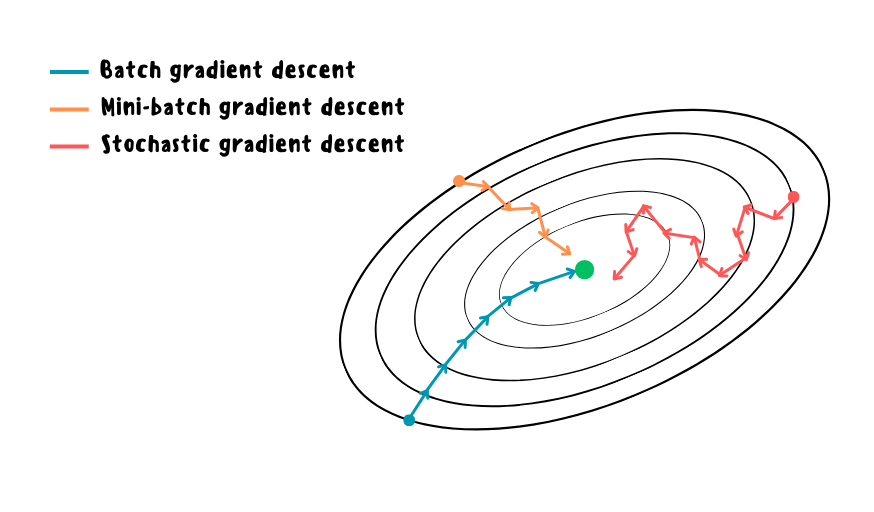

## **Более быстрые и точные оптимизаторы**
Помимо того, что градиентный спуск в своём классическом представлении плохо подходит для невыпуклых случаев из-за вышеописанных проблем, может также возникнуть проблема с "седловыми точками", когда на поверхности функции потерь в виде седла имеются точки, в которых значение функции максимально по одним направлениям и минимально по другим, то есть в данных точках будет практически нулевое снижение градиентов и они ошибочно могут быть приняты моделью за оптимум. Поэтому для быстрого поиска оптимального решения используются более интересные стохастические (mini-batch) оптимизации, про самые популярные из которых сейчас и пойдёт речь.



### **Momentum**
Предположим, что со склона с кочками катится мяч, который сначала будет двигаться медленно, но по мере накопления кинетической энергии его скорость будет расти, что ему поможет преодолеть небольшие кочки и остановить своё движение в более глубокой. Именно данный принцип лежит в основе моментной оптимизации. Momentum принимает во внимание значения предыдущих градиентов, которые используются для определения направления и скорости перемещения в пространстве параметров $v_t$ (называется вектором первого момента, поскольку масса в данном случае равна 1), а для предотвращения её быстрого увеличения используется коэффициент ослабления импульса $\beta$, который отвечает за силу влияния предыдущего градиента на текущий, то есть выступает в качестве механизма трения мяча о поверхность: значение 0 означает высокое трение, а 1 его отсутствие. Обычно значение $\beta$ устанавливается 0.9.

**Алгоритм обновления параметров моментной оптимизации**

$v_t \leftarrow \beta v_{t-1} - \alpha dw_{t-1}$

$w_t \leftarrow w_{t-1} + v_t$

Momentum способен решить сразу две проблемы: плохую обусловленность матрицы Гессе и дисперсию стохастического градиента. С другой стороны, из-за вычисления градиента функции потерь в локальной позиции модель может колебаться вокруг локальных минимумов, что в свою очередь увеличивает время схождения.

Хотя во многих статьях $v_t$ обозначается как $m_t$, а $s_t$ как $v_t$, на данный момент нет единого стандарта и в разных статьях можно встретить для них разные обозначения, но для унификации во всех примерах будут использоваться следующие обозначения: $v_t$ — это первый момент или ещё по-другому экспоненциально взвешенное скользящее среднее градиентов, а $s_t$ — второй момент или экспоненциально взвешенное скользящее среднее квадратов градиентов, однако в случае AdaGrad это просто квадрат градиентов.

### **Nesterov momentum**
Для решения вышеописанной проблемы применяется небольшая оптимизация, суть которой заключается в вычислении градиентов не в локальной позиции, а чуть дальше в направлении момента. Другими словами, функция потерь будет снижаться не в текущей позиции, а в которой якобы должна оказаться в будущем, следуя направлению импульса.

**Алгоритм обновления параметров моментной оптимизации Нестерова**

$v_t \leftarrow \beta v_{t-1} - \alpha d(w_{t-1} + \beta v_{t-1} )$

$w_t \leftarrow w_{t-1} + v_t$


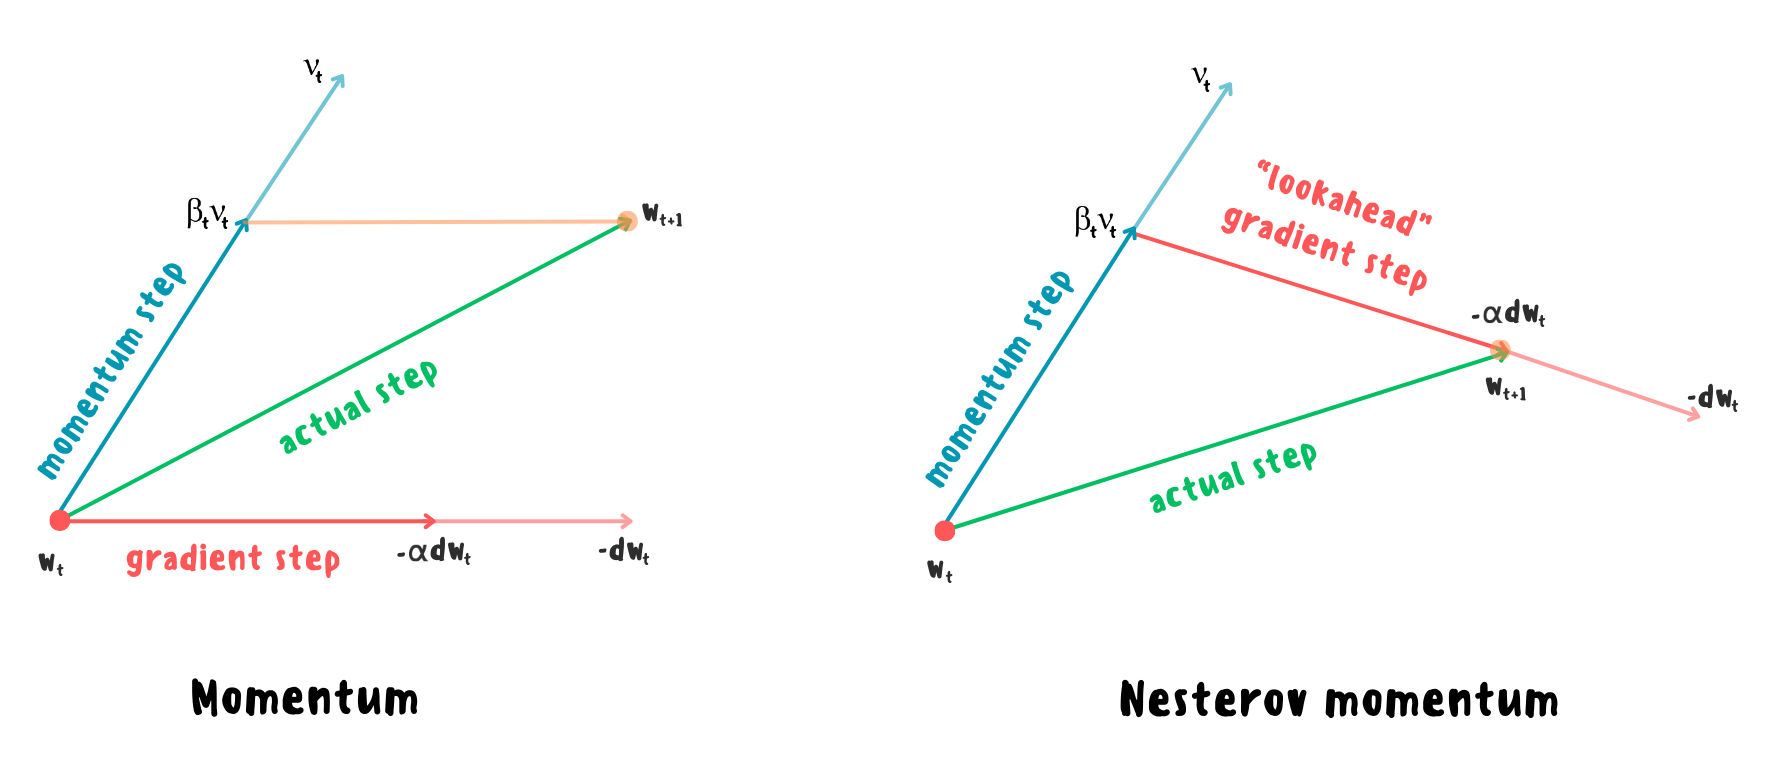

Такой подход позволяет сойтись гораздо быстрее и чуть ближе к оптимуму, однако он всё ещё может быть чувствительным в отношении одних направлений пространства параметров и нечувствительным в других из-за трудностей подбора оптимальной скорости обучения. Ниже будут представлены оптимизации градиентного спуска с адаптивной скоростью обучения.

### **AdaGrad**
Adaptive Gradient является одной из первых оптимизаций градиентного спуска с адаптивным шагом, в которой снижается градиент вдоль самых крутых направлений. Проще говоря, на каждом шаге происходит обновление параметров модели с учётом значений как предыдущих градиентов, так и их квадратов.

**Алгоритм обновления параметров AdaGrad**

$s_t \leftarrow s_{t-1} + dw_{t-1}^2$

$w_t \leftarrow w_{t-1} - \frac{\alpha}{\sqrt{s_t + \epsilon}} dw_{t-1}$

$\epsilon = 1e-8 \ - \ $ smoothing parameter to avoid division by zero

Такой простой подход позволяет алгоритму быстро начать обучение, а затем замедлить его, когда градиент становится меньше или меняет знак. Однако на практике AdaGrad хорошо справляется с выпуклыми случаями, а вот при обучении нейронных сетей нередко останавливается слишком рано из-за быстрого снижения скорости обучения, так и не достигнув глобального оптимума.

### **RMSProp**
RMSProp (Root Mean Square Propagation) — модификация AdaGrad, адаптированная для лучшей работы в невыпуклом случае. Основная идея заключается в изменении способа агрегирования градиента на экспоненциально взвешенное скользящее среднее. Другими словами, вместо накопления всех квадратов градиента с начала обучения, накапливаются квадраты градиента только из самых последних итераций.

**Алгоритм обновления параметров RMSProp**

$s_t \leftarrow \beta s_{t-1} + (1 - \beta) dw_{t-1}^2$

$w_t \leftarrow w_{t-1} - \frac{\alpha}{\sqrt s_t + \epsilon} dw_{t-1}$

В целом, RMSProp является крайне эффективной оптимизацией, но не самой лучшей. Например, могут возникнуть трудности обучения в многомерных пространствах из-за проблем с масштабированием градиентов в разных направлениях.

### **Adam и его модификации**
Adam (Adaptive Moment Estimation) объединяет в себе концепции Momentum и RMSProp, практически являясь серебряной пулей в задачах стохастической оптимизации. Как можно заметить, расчёт моментов в Adam очень схож с Momentum и RMSProp за исключением того, что к ним применяется поправка на смещение. В целом, благодаря таким улучшениям Adam сходится быстрее и лучше предшественников, а также более устойчив к подбору гиперпараметров, что делает его более стабильным решением в большинстве случаев.

**Алгоритм обновления параметров Adam**

$v_t \leftarrow \beta_1 v_{t-1} + (1 - \beta_1) dw_{t-1}$

$s_t \leftarrow \beta_2 s_{t-1} + (1 - \beta_2) dw_{t-1}^2$

$w_t \leftarrow w_{t-1}  - \alpha \frac{v_t}{\sqrt s_t + \epsilon}$

$v_t \leftarrow \frac{v_t}{1 - \beta_1^t}\ - \ $ bias correction

$s_t \leftarrow \frac{s_t}{1 - \beta_2^t}\ - \ $ bias correction

$\beta_1 = 0.9, \ \ \beta_2 = 0.99 \ \ $ by default

С другой стороны, данный алгоритм более сложен в анализе и может быть чувствителен к шуму, что может привести к проблемам со сходимостью, а также он требует больших объемов памяти, поскольку хранит не только параметры модели, но а также информацию о градиентах и накопленном импульсе. Помимо этого, у Adam и всех предыдущих алгоритмов есть ещё один неприятный недостаток: если продолжить обучение модели после прерывания в некоторой точке, придётся восстанавливать не только веса модели из данной точки, но а также и всю информацию о накопленных параметрах.

Однако время не стоит на месте и были разработаны модификации Adam, призванные устранить в той или иной степени недостатки, описанные выше. К наиболее популярным и интересным модификациям можно отнести следующие:

- **AdaMax** использует экспоненциально взвешенную норму бесконечности для обновления вектора второго момента, то есть скорость обучения изменяется, основываясь максимальной величине градиента в истории:

$$s_t \leftarrow max(\beta_2 s_{t-1} |dw_{t-1}|)$$

- **Nadam** (Nesterov-accelerated Adaptive Moment Estimation) использует другую поправку на смещение для вектора первого момента:

$$\hat v_t \leftarrow \frac{(1 - \beta_1^t) dw_{t-1}}{1 - \Pi_{i=1}^{t} \beta_1^i} + \frac{\beta_1^{t+1} v_t}{1 - \Pi_{i=1}^{t+1} \beta_1^i}$$

- **AdamW** добавляет L2-регуляризацию к функции потерь и при обновлении весов:

$$w_t \leftarrow w_{t-1}  - \frac{\alpha v_t}{\sqrt s_t + \epsilon} + \lambda w_{t-1}$$

- **Yogi** обновляет вектор второго момента с учётом разности второго момента и квадрата градиента:

$$s_t \leftarrow  s_{t-1} - (1 - \beta_2) sign(s_{t-1} - dw_{t-1}^2) dw_{t-1}^2$$

- **Adan** (Adaptive Nesterov Momentum) использует модифицированный New Nesterov Momentum (NME позволяет избежать дополнительных затрат на вычисление градиента в точке экстраполяции) для оценки первого и второго моментов, что позволяет значительно ускорить сходимость и найти приближённую точку первого порядка с заданной точностью $\epsilon$. Схема работы алгоритма выглядит следующим образом:


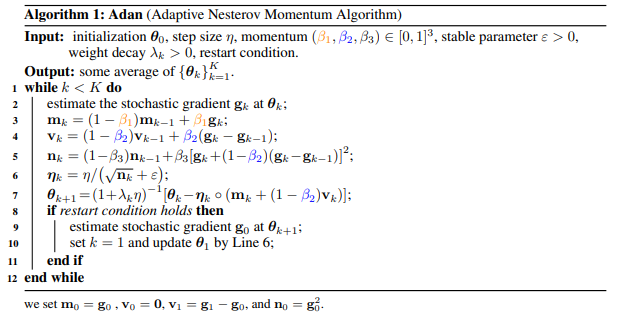

### **Обучение и визуализация оптимизаторов**

Для наглядности рассмотрим небольшой пример работы различных оптимизаторов на данных [Boston Housing](https://www.kaggle.com/datasets/arunjangir245/boston-housing-dataset). Сначала мы создадим простую нейросеть в Pytorch и обучим её на всех тренировочных данных, на которых после же оценим снижение потерь оптимизаторов на каждой итерации. Также для любителей Keras мы  обучим простую нейросеть на мини-пакетах, но уже оценим снижение потерь на тестовом наборе.

**Загрузка и подготовка датасета**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df_path = "/content/drive/MyDrive/BostonHousing.csv"
boston = pd.read_csv(df_path)
print(boston)

        crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...  ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273   

     ptratio       b  lstat  medv  
0       15.3  396.90   4.98  24.0  
1       17.8  396.90   9.14  21.6  
2       17.8  3

In [ ]:
print(boston.isna().sum())

crim       0
zn         0
indus      0
chas       0
nox        0
rm         5
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64


In [ ]:
boston.dropna(inplace=True)

X, y = boston.iloc[:, :-1].values, boston.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_s = StandardScaler().fit_transform(X_train)
X_test_s = StandardScaler().fit_transform(X_test)

**Параметры нейросети**

In [ ]:
nn_params = {'in_features': X.shape[1], 'h1': 16, 'h2': 8, 'out': 1}

**Сравнение оптимизаторов Pytorch на тренировочных данных**

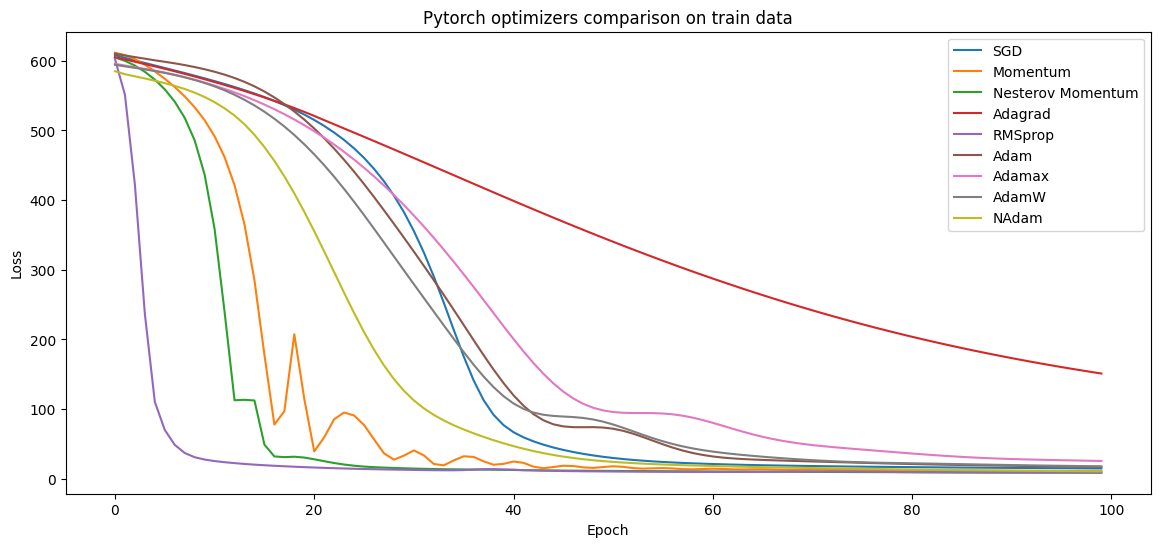

In [ ]:
from torch import nn, optim, FloatTensor, relu, manual_seed


class TorchNN(nn.Module):
    def __init__(self, in_features, h1, h2, out):
        super(TorchNN, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, out)

    def forward(self, x):
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x)

        return x


def torch_losses(data, model, optim_cls, optim_params, num_epochs=100):
    losses = []
    X_train, y_train = data
    criterion = nn.MSELoss()
    optimizer = optim_cls(model.parameters(), **optim_params)

    for epoch in range(num_epochs):
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses


manual_seed(0)
X_train_s_tensor = FloatTensor(X_train_s)
y_train_tensor = FloatTensor(y_train).view(-1, 1)

torch_optimizers = [
    (optim.SGD, 'SGD', {'lr': 0.001}),
    (optim.SGD, 'Momentum', {'lr': 0.001, 'momentum': 0.9}),
    (optim.SGD, 'Nesterov Momentum', {'lr': 0.001, 'momentum': 0.9, 'nesterov': True}),
    (optim.Adagrad, 'Adagrad', {'lr': 0.01}),
    (optim.RMSprop, 'RMSprop', {'lr': 0.01}),
    (optim.Adam, 'Adam', {'lr': 0.01}),
    (optim.Adamax, 'Adamax', {'lr': 0.01}),
    (optim.AdamW, 'AdamW', {'lr': 0.01}),
    (optim.NAdam, 'NAdam', {'lr': 0.01})
    ]

# Visualization
plt.figure(figsize=(14, 6))

for optim_cls, optim_name, optim_params in torch_optimizers:
    nn_model = TorchNN(**nn_params)
    t_losses = torch_losses((X_train_s_tensor, y_train_tensor), nn_model, optim_cls, optim_params)
    plt.plot(range(len(t_losses)), t_losses, label=f'{optim_name}')

plt.title('Pytorch optimizers comparison on train data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Сравнение оптимизаторов Keras на тестовых данных**

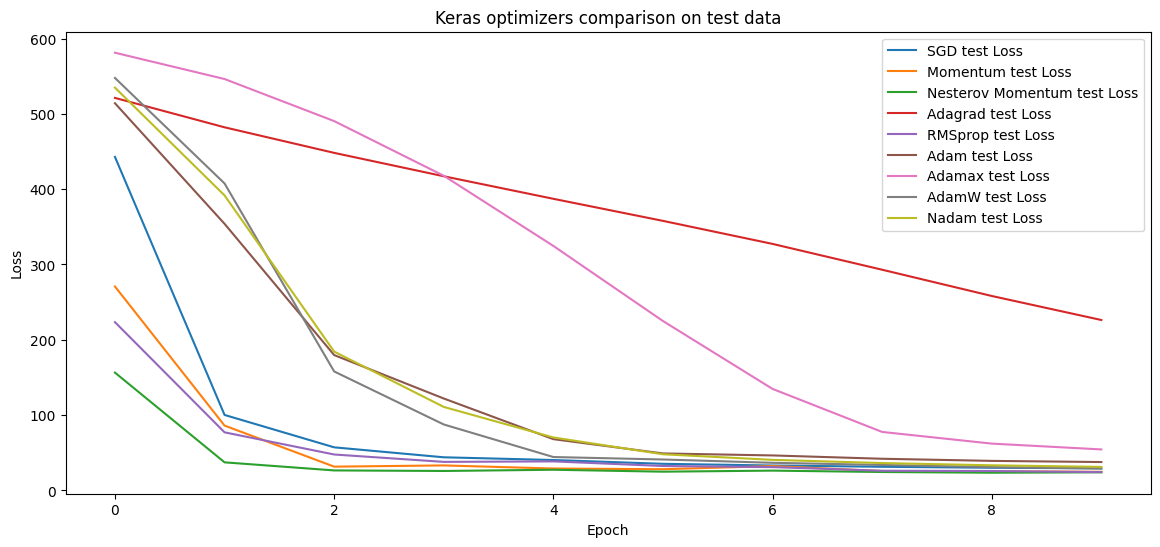

In [ ]:
from keras import optimizers
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import set_random_seed


def create_keras_nn(optimizer, in_features, h1, h2, out):
    model = Sequential()
    model.add(Dense(input_shape=(in_features,), units=h1, activation='relu'))
    model.add(Dense(input_shape=(h1,), units=h2, activation='relu'))
    model.add(Dense(units=out))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    return model


def keras_losses(train_data, test_data, optimizers, nn_params, num_epochs=10):
    losses = []
    X_train, y_train = train_data
    X_test, y_test = test_data

    for name, optimizer in optimizers:
        model = create_keras_nn(optimizer, **nn_params)
        model_history = model.fit(X_train, y_train, batch_size=32, epochs=num_epochs,
                                  verbose=0, validation_data=(X_test, y_test))
        losses.append((name, model_history.history['val_loss']))

    return losses


set_random_seed(0)

keras_optimizers = [
    ('SGD', optimizers.SGD(learning_rate=0.001)),
    ('Momentum', optimizers.SGD(learning_rate=0.001, momentum=0.9)),
    ('Nesterov Momentum', optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)),
    ('Adagrad', optimizers.Adagrad(learning_rate=0.01)),
    ('RMSprop', optimizers.RMSprop(learning_rate=0.01)),
    ('Adam', optimizers.Adam(learning_rate=0.01)),
    ('Adamax', optimizers.Adamax(learning_rate=0.01)),
    ('AdamW', optimizers.AdamW(learning_rate=0.01)),
    ('Nadam', optimizers.Nadam(learning_rate=0.01))
    ]


plt.figure(figsize=(14, 6))

k_losses = keras_losses((X_train_s, y_train), (X_test_s, y_test), keras_optimizers, nn_params)

for name, k_loss in k_losses:
    plt.plot(k_loss, label=name + ' test Loss')

plt.title('Keras optimizers comparison on test data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Промежуточные выводы**

Поскольку SDG, Momentum и Nesterov momentum являются менее стабильными алгоритмами и больше всего зависят от начальных значений learning rate, для них была задана меньшая скорость обучения, чем для остальных методов. На первом графике видно, что даже в таком случае эти алгоритмы немного подвержены колебаниям, хотя и быстро сошлись. Второй же график хорошо демонстрирует как обучение на мини-пакетах значительно ускоряет сходимость алгоритмов. В случае с AdaGrad возникла классическая проблема резкого снижения скорости обучения, которую в данном случае можно легко решить, установив изначально более высокое значение. А вот RMSprop хорошо сработал в обоих случаях и даже лучше Adam-подобных оптимизаторов.

Отсюда следует интересный вывод, что адаптивные методы могут сходиться быстрее предшественников далеко не в каждой ситуации, но зато они гораздо стабильнее минимизируют функцию потерь. Конкретно в данном случае это означает, что если мы установим одинаковые произвольные значения learning rate для всех оптимизаторов, то неадаптивные методы зачастую будут снижаться с очень большими рывками и могут не сойтись вообще, в то время как адаптивные методы будут более плавно сходиться, хоть и медленно.

Стоит добавить, что данный пример лишь в очередной раз доказывает, что нет универсального оптимизатора, который являлся бы лучшим выбором для всех задач машинного обучения, поскольку многое зависит от самых разных факторов, включая природу данных, сложность модели и цели обучения. Однако это не отменяет тот факт, что в случае со сложными ландшафтами потерь адаптивные методы практически всегда будут превосходить простые стохастические оптимизаторы не только в плане стабильности, но и конечно же в скорости. Поэтому в большинстве ситуаций RMSprop и особенно семейство оптимизаторов Adam можно рассматривать в качестве хорошего стартового решения.



## **Нарушение работы адаптивных методов со скользящим средним**
Поскольку работа всех диагональных адаптивных методов в той или иной степени основана на использовании покоординатного learning rate, то в случае, когда последовательность $s_t$ перестаёт монотонно неубывать, алгоритм не может нормально сойтись к локальным минимумам. Как правило, такая ситуация означает приближение к критическим точкам и происходит при уменьшении $dw_{t-1}^2$  в сравнении с предыдущей накопленной историей с точностью до некоторой константы.

Данную проблему можно устранить путём наделения таких алгоритмов долговременной памятью о прошлых градиентах для исключения отрицательных регуляризаторов подобно тому, как это реализовано в **AMSGrad**. Проще говоря, выполняется условие $s_t >= s_{t-1}$, что возможно благодаря простому трюку:

$$\hat s_0 = 0, \ \hat s_t = max(\hat s_{t-1}, s_t) \ and \ \hat S_t = \ diag(\hat s_t)$$

Однако стоит иметь в виду, что в таком случае требуются дополнительные расходы памяти, что может быть особенно проблематично для моделей с разреженными параметрами. Решить данную проблему можно за счёт использования непостоянных $\beta_1^t$ и $\beta_2^t$, что было предложено в алгоритме **AdamNC**:

$$v_t \leftarrow \beta_1^t v_{t-1} + (1 - \beta_1^t) dw_{t-1} \\
s_t \leftarrow \beta_2^t s_{t-1} + (1 - \beta_2^t) dw_{t-1}^2$$

Помимо того, что такой подход не требует изменения структуры оригинального Adam, он также позволяет достичь хороших показателей сходимости.

Однако в работе Tran Thi Phuong и Le Trieu Phong было показано, что проблема в доказательстве сходимости AMSGrad заключается в обработке гиперпараметров, рассматривая их как равные, в то время как это не совсем верно. Так авторами был представлен контрпример в контексте простой задачи выпуклой оптимизации, который показывает эту проблему. Алгоритм должен сходиться согласно следующей лемме:

$$R(T) \leq \sum_{i=1}^{d} \sum_{t=1}^{T} \frac{\sqrt{\hat{s}_{t,i}}}{2\alpha_t(1 - \beta_1^t)} ((w_{t,i} - w^*_{i})^2 - (w_{t+1,i} - w^*_{i})^2) + \sum_{i=1}^{d} \sum_{t=1}^{T} \frac{\alpha_t}{1 - \beta_1} \frac{v^2_{t,i}}{\sqrt{\hat{s}_{t,i}}} + \\ + \sum_{i=1}^{d} \sum_{t=2}^{T} \frac{\beta_1^t \sqrt{\hat{s}_{t-1,i}}}{2\alpha_{t-1}(1 - \beta_1)} (w_{t,i} - w^*_{i})^2$$

Однако проблема заключается в равенстве, которое на самом деле может быть как положительным, так и отрицательным:

$$(w_{t,i} - w^*_{i})^2 - (w_{t+1,i} - w^*_{i})^2$$

Поэтому авторы представили новое доказательство сходимости для AMSGrad, а также алгоритм **AdamX** на его основе, который учитывает различия в гиперпараметрах и позволяет избежать проблемы выше. Решение выглядит следующим образом:

$$\hat s_1 = s_1, \ \hat s_t = max \left(\frac{(1 - \beta_1^t)^2}{(1 - \beta_1^{t-1})^2} \hat s_{t-1}, s_t \right) \ \ if \ \ t \geq 2, \ and \ \hat S_t = diag(\hat s_t)$$

Но стоит иметь в виду, что как и в случае с AMSGrad, AdamX также требует дополнительных расходов памяти.

## **Стратегии изменения скорости обучения**
Как можно было заметить, скорость обучения является одним из ключевых параметров в градиентном спуске, которая может оказывать значительное влияние на сходимость и конечную ошибку модели. Помимо вышеописанных стратегий сокращения скорости обучения, ещё одними из самых популярных являются следующие:
- 1) $\alpha = \frac{1}{1 + decay \_ rate * t} \alpha_0 \ - \ $ smooth decay;
- 2) $\alpha = k^t \alpha_0 \ - \ $ exponential decay;
- 3) $\alpha = \frac{k}{\sqrt{t}} \alpha_0$, $k\ - \ $ constant, $t \ - \ $ num iterations;
- 4) дискретное сокращение, когда после заданного количества итераций шаг уменьшается с определённым размером.

Не смотря на то, что на сегодняшний день в алгоритмах на основе градиентного спуска используется автоматическое снижение скорости обучения как в библиотеке sckit-learn, так и в библиотеках глубокого обучения, подбор learning rate всё ещё нужно выполнять аккуратно: алгоритм может преждевременно выйти на плато либо вовсе разойтись. Пример приведён на графике ниже.

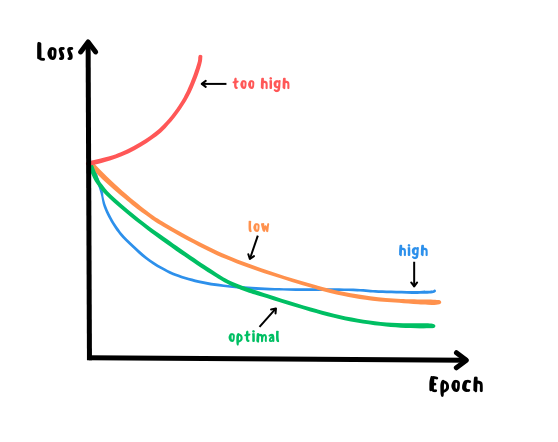

Другим подходом в изменении скорости обучения является её резкое увеличение, чтобы "вытолкнуть" модель из возможных локальных минимумов, в которых она может застрять в процессе обучения. Такой подход называется **Warm Restart** и включает в себя циклическое изменение скорости обучения: начиная с высокого значения, скорость постепенно снижается по определённому правилу, а затем после достижения минимального значения она снова повышается. Это особенно полезно, когда модель сходится к неоптимальному решению из-за плохой инициализации или когда пространство параметров содержит множество локальных минимумов.

Одним из популярных методов, использующий такой подход, является [CosineAnnealingWarmRestarts](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html#torch.optim.lr_scheduler.CosineAnnealingWarmRestarts), в котором скорость обучения регулируется на основе "косинусного отжига" с перезапусками, возвращаясь к своему начальному значению:

$$η_t = η_{min} + \frac{1}{2}(η_{max} - η_{min})(1 + \cos(\frac{T_{cur}}{T_{i}}\pi))$$

Где:

- $\eta_t$ — скорость обучения в момент времени $t$;

- $\eta_{\text{max}}$ — начальная скорость обучения;

- $\eta_{\text{min}}$ — минимальная скорость обучения;

- $T_{\text{cur}}$ — количество эпох с момента последнего перезапуска;

- $T_i$ — количество эпох между двумя перезапусками.

С полным списком "планировщиков" скорости обучения можно ознакомиться [здесь](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) и [здесь](https://www.tensorflow.org/api_docs/python/tfm/optimization/lr_schedule).

## **Работа с большими мини-пакетами**
Рассмотрим ситуацию, когда нам необходимо обучить сложную нейронную сеть на больших данных с использованием нескольких графических процессоров (GPU). Одно из самых простых решений будет заключаться в вычислении стохастических градиентов для каждого батча отдельно на разных GPU с их последующим усреднением по всем GPU на каждом этапе обновления параметров модели.

По сути, такой подход равносилен обучению с одним огромным батчем и на первый взгляд может показаться оптимальным, но не всё так просто, поскольку это может привести к такому явлению как generalization gap, при котором возникает ухудшение обобщающей способности модели (иногда значительное). Почему так происходит? При использовании батча большого размера оптимизатор начинает лучше распознавать ландшафт функции потерь для определённой выборки, что увеличивает шансы скатиться в узкие локальные минимумы с низкой обобщающей способностью. Тогда даже при незначительном сдвиге ландшафта (при так называемом distributional shift, когда происходит переход от тренировочной выборки к тестовой) значение функции потерь может резко увеличиться. Проще говоря, большие батчи могут приводить к переобучению.

С другой стороны широкие локальные минимумы более устойчивы к изменениям в ландшафте функции потерь и способны обеспечить лучшую обобщающую способность, а для того чтобы в них попадать можно использовать оптимизаторы с более точным динамическим подбором learning rate, про которые далее пойдёт речь. Однако перед этим стоит добавить, что использование маленьких батчей в оптимизации также является не самой хорошей идеей, поскольку это может привести к более шумным оценкам градиента и в конечном счёте к недообучению модели.


### **LARS**

Первым на очереди будет Layer-wise Adaptive Rate Scaling (LARS), использующий momentum в качестве базового алгоритма. Его основная идея заключается в подборе скорости обучения не для каждого нейрона или всей нейросети, а для каждого слоя отдельно. Проще говоря, обновление весов происходит с учётом локального learning rate, рассчитанного как отношение нормы весов к сумме нормы весов и градиентов. Работа алгоритма показана ниже:



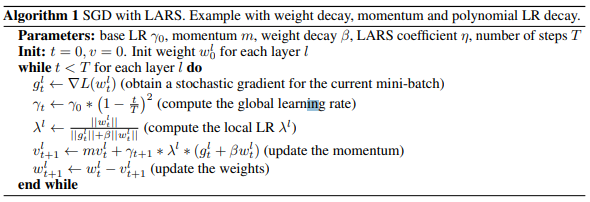

Не смотря на то, что такой метод позволяет использовать батчи большого размера для обучения без потери качества, он плохо справляется со сложными моделями, где каждый слой имеет важное значение для общей производительности, например, с моделями внимания, такими как BERT. Это связано с тем, что если в одном из слоёв сети наблюдается нестабильное снижение градиентов, то к этому слою будет применяться меньшая скорость обучения, а поскольку LARS стремится синхронизировать обновления по всем слоям, то скорости обучения для более "стабильных" слоёв также будут снижены для предотвращения расхождения в обучении. Следовательно, более "стабильные" слои будут обновляться не так быстро, как могли бы, что в итоге значительно замедлит обучение всей модели и окажет негативное влияние на конечный результат.


### **LAMB**

В ответ на это был разработан более продвинутый оптимизатор, известный как Layer-wise Adaptive Moments Based optimizer (LAMB), который можно рассматривать как применение LARS к оптимизатору Adam. Основное различие заключается в использовании двойной стратегии нормализации:
- 1) Нормализация каждого измерения (или параметра модели) относительно квадратного корня из второго момента, используемого в Adam. Это означает, что каждый параметр модели обновляется с учётом его собственной истории изменений, что помогает более точно настраивать веса модели.
- 2) Применение послойной нормализации. Другими словами, обновления параметров модели происходят с учётом масштаба каждого слоя в нейронной сети. Это помогает предотвратить слишком большие изменения в весах слоёв и избежать нестабильности в процессе обучения.

Алгоритм работает следующим образом:

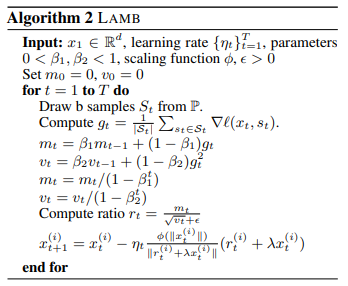

Такой подход позволил значительно улучшить процесс обучения модели BERT даже на батчах большого размера без потери точности. Так команде Google Brain удалось сократить время обучения с 3 дней до всего лишь 76 минут, увеличив размер пакета до
предела памяти модуля TPUv3. Более того, как и другие оптимизаторы, LAMB имеет ряд модификаций, способных не только ускорить обучение (как в NVLAMB благодаря предварительной нормализации градиентов), но и сделать его ещё более стабильным в плане сходимости (как в N-LAMB и NN-LAMB).

## **Прокcимальные методы**
Проксимальные методы — это класс алгоритмов, предназначенных для решения задач выпуклой оптимизации негладких функций. Основная идея таких методов заключается в замене исходной сложной задачи оптимизации на серию более простых подзадач, аппроксимируя новое решение к текущему. Другими словами, данные методы представляют собой обобщение проективных градиентных методов.

### **Метод проксимальной минимизации**

Может быть полезен в тех случаях, когда трудно
минимизировать функцию потерь $f$, но легко (или хотя бы проще) минимизировать её регуляризованную версию, то есть $f$ плюс квадратичная величина. Данный алгоритм имеет множество разных интерпретаций в зависимости от целей использования. Наиболее популярными являются следующие:

- 1) **Регуляризация Тихонова** позволяет находиться $w_{k+1}$ недалеко от $w_k$ и ускоряет сходимость, особенно при использовании метода сопряжённого градиента. Это обусловлено тем, что
наличие регуляризации обеспечивает сильную выпуклость задачи:

$$w_{k+1} = \text{argmin} \left\{ f(w) + \frac{1}{2\alpha_k} \| w - w_k \|^2 \right\} = prox_{\alpha_k f}(w_k)$$

- 2) **Градиентный поток** обеспечивает сходимость в точке минимума из любой начальной точки при $t \to \infty$:

$$\frac {d}{dt} w(t) = - \nabla f(w(t))$$

Решив данное дифференциальное уравнение с помощью прямой схемы Эйлера, получим:

$$w_{k+1} = w_k - \alpha \nabla f(w_k)$$

Однако такое решение менее стабильно, чем с использованием обратной схемы Эйлера. Тогда задача приобретает вид:

$$\frac{w_{k+1} - w_k}{\alpha} = - \nabla f(w_{k+1})$$

Поскольку уравнение представлено в неявном виде, а его левая часть является по сути градиентом функции $g(w^*)$ в точке $w_{k+1}$, тогда для выпуклого случая:

$$\nabla (f(w^*) + g(w^*))(w_{k+1}) = 0 \Rightarrow \\ \Rightarrow w_{k+1} = \text{argmin} \left\{ f(w^*) + \frac{1}{2\alpha_k} \| w^* - w_k \|^2 \right\} = prox_{\alpha_k f}(w_k)$$

Также стоит отметить, что идея градиентного потока может быть обобщена на случаи, когда $f$ не дифференцируется с помощью субградиентного дифференциального включения:

$$\frac {d}{dt} w(t) \in - \partial f(w(t))$$

- 3) **Итеративное уточнение** основано на идее асимптотически исчезающей регуляризации Тихонова и используется для решения линейных уравнений вида $Xw = y$ с использованием факторизации Холецкого для $X + \frac{1}{\alpha} I$.

Рассмотрим задачу минимизации квадратичной функции:

$$f(w) = \frac{1}{2} w^T X w - y^T w$$

где $X \in S_+^n$ (множество симметричных положительных полуопределённых $n$ x $n$ матриц). Такая задача эквивалентна решению системы линейных уравнений $Xw = y$. Когда $X$ несингулярно, то единственным решением является $w = X^{-1} y$. Такую же проблему можно заметить в методе наименьших квадратов. Проксимальный оператор для $f$ при $w_k$ можно выразить аналитически:

$$prox_{\alpha_k f}(w_k) = \text{argmin} \left\{ \frac{1}{2} w^T X w - y^T w + \frac{1}{2} \| w - w_k \|^2   \right\} = \left(X + \frac{1}{\alpha} I \right)^{-1} \left(y + \frac{1}{\alpha} w_k \right)$$

Переписав данное выражение, получим:

$$w_{k+1} = w_k + \left(X + \frac{1}{\alpha} I \right)^{-1} (y - X w_k)$$

### **Проксимальный градиентный метод (PGM)**

Применяется для решения проблемы вида $min \rightarrow f(w) + g(w)$, где $f$ является гладкой (дифференцируемой), а $g$ негладкой функцией, для которой существует быстрый проксимальный оператор. Тогда, выполнив градиентный шаг по $f$ и проксимальный по $g$, получим итеративный процесс вида:

$$w_{k+1} = prox_{\alpha_k g} (w_k - \alpha_k \nabla f(w_k))$$

Ещё такой процесс называется forward-backward splitting, где forward относится к шагу градиента, а backward — к проксимальному шагу.

PGM также имеет различные интерпретации:

- 1) **Majorization-minimization** используется для решения проблемы вида:

$$min \rightarrow q_{\alpha}(w, w_k) = \frac{1}{2} \| w - (w_k \ - \alpha_k \nabla f(w_k)) \|^2  + \alpha g(w)$$

А процесс обновления $w_{k+1}$ выглядит следующим образом:

$$w_{k+1} = \text{argmin} \ q_{\alpha}(w, w_k)$$

- 2) **Fixed point iteration** основано на идее, что существует фиксированная точка $w^*$, которая является решением $min \rightarrow f(w) + g(w)$ лишь в том случае, когда она является точкой оператора forward-backward:

$$(I + \alpha \partial g)^{-1} (I - \alpha \nabla f)$$

Тогда решение приобретает вид:

$$w^* = (I + \alpha \partial g)^{-1} (I - \alpha \nabla f) (w^*) = prox_{\alpha g} (w^* - \alpha_k \nabla f(w^*))$$

- 3) **Forward-backward интегрирование градиентного потока** представляет собой метод численного интегрирования дифференциального уравнения градиентного потока, в котором используется прямой Шаг Эйлера для дифференцируемой части $f$ и обратный шаг Эйлера для
возможно недифференцируемой части $g$. Если исходить предположения, что $g$ является также дифференцируемой, то систему градиентного потока можно представить в виде:

$$\frac {d}{dt} w(t) = - \nabla f(w(t)) - \nabla g(w(t))$$

Тогда получим процесс обновления, называемый forward-backward splitting:

$$w_{k+1} = (I + \alpha \nabla g)^{-1} (I - \alpha \nabla f) w_k$$

Также стоит добавить, что существует вариант **ускоренного проксимального градиентного метода**, который включает в себя этап экстраполяции:

$$z_{k+1} = w_k + p_k (w_k - w_{k-1})$$

$$w_{k+1} = prox_{\alpha_k g} (z_{k+1} - \alpha_k \nabla f(z_{k+1}))$$

где $p_k$ — параметр экстраполяции, а одна из самых простых схем его расчёта выглядит следующим образом:

$$p_k = \frac {k}{k + 3}$$


### **ISTA (Iterative Shrinkage(Soft)-Thresholding Algorithm)**

Данный метод можно рассматривать как обновление проксимального градиента, применяемое к L1-регуляризованной задаче наименьших квадратов:

$$\|Xw - y\|^2 + \lambda \|w\| \rightarrow min$$

Тогда прокс-оператор для l1-нормы будет выглядеть следующим образом:

$$prox_{\lambda \alpha} (w) = argmin \left\{\frac{1}{2 \alpha} \|w - w^* \|^2 + \lambda \|w^* \| \right\} = argmin \left\{\sum_{i=1}^d  \left[ \frac{1}{2 \alpha} (w_i - w_i^*) + \lambda |w_i^*| \right] \right\} = T_{\lambda \alpha} (w)$$

где $T_{\lambda \alpha} (w)$ — оператор с плавным установлением порога, который для одномерной задачи является решением со следующим правилом:

$$ T_{\lambda \alpha} (w_i) =
\begin{cases}
    w_i - \lambda \alpha, \ \ w_i \geq \lambda \alpha \\
    0, \ \ \ \ \ \ \ \ \ \ \ \ \  |w_i| \leq \lambda \alpha \\
    w_i + \lambda \alpha, \ \ w_i \leq - \lambda \alpha  \\
\end{cases} $$

Отсюда получим градиентный шаг обновления:

$$w_{k+1} = T_{\lambda \alpha_k} (w_k - \alpha_k X^T (Xw_k- y))$$

Как можно заметить, данный метод позволяет получить разреженную модель, поскольку часть координат будет зануляться в случае $|w_i| \leq \alpha$, что особенно полезно в задачах компьютерного зрения и обработки сигналов. Однако ISTA в чистом виде имеет низкую скорости сходимости, поэтому на практике используются его различные модификации. Например, FISTA (от слова Fast), основанное на ускорении Нестерова, где используется дополнительный шаг экстраполяции:

$$t_{k+1} = \frac{1 + \sqrt{1 + 4t_k^2}}{2}$$

$$z_{k+1} = w_k + \frac{t_k - 1}{t_{k+1}} (w_k - w_{k-1})$$

$$w_{k+1} = prox_{\lambda \alpha} (z_{k+1}) = T_{\lambda \alpha_k}(z_{k+1} - \alpha_k \nabla f(z_{k+1}))$$

Такой подход позволил достичь скорости сходимости $O(1/k^2)$ вместо $O(1/k)$ как в ISTA. К слову, на сегодняшний день FISTA также имеет ряд модификаций, делающих его работу более стабильной и быстрой в ряде случаев.

## **Методы второго порядка**

Методы оптимизации второго порядка — это алгоритмы, которые используют информацию о вторых производных (гессиане) функции потерь для более быстрого и точного нахождения точек минимума с очень неровным и сложным ландшафтом потерь.

Вторая производная характеризует скорость изменения градиента функции потерь за счёт измерения её кривизны, то есть позволяет оценить ожидаемое улучшение от шага градиентного спуска. На примере квадратичной функции это будет означать следующее:

- 1) Если кривизна отрицательная (отрицательное значение второй производной), то функция потерь снижается быстрее, чем ожидалось на основе прогноза градиента. Это может привести к более быстрому достижению минимума, но также увеличивает риск его перепрыгнуть при использовании больших шагов.
- 2) Если кривизна нулевая (нулевое значение второй производной), то градиент точно указывает на изменение функции потерь. В этом случае, градиентный спуск будет эффективно минимизировать функцию потерь, поскольку нет ни ускорения, ни замедления в изменении её значений.
- 3) Если кривизна положительная (положительное значение второй производной), то функция потерь снижается медленнее, чем ожидалось на основе прогноза градиента. Это говорит о том, что при использовании слишком больших шагов можно не только замедлить процесс сходимости, но и увеличить значение функции потерь, отдаляясь от оптимального решения.

### **Метод Ньютона**

Использует разложение в ряд Тейлора второго порядка для приближения функции $f(w)$ в окрестностях точки $t$:

$$f(w + t) \approx f(w) + \nabla f(w)t + \frac{1}{2} \nabla ^ 2 (w) t^2$$

Приравняв к нулю $\nabla f(w + t)$, получим оптимальное решение, то есть направление спуска:

$$0 = \frac{d f(w + t)}{dt} = \nabla f(w) + \nabla ^ 2 f(w) \Rightarrow \\
\Rightarrow t = - \frac {\nabla f(w)}{\nabla ^ 2 f(w)} = - H^{-1}(w) \nabla f(w)$$

Тогда получим итеративный процесс обновления параметров следующего вида:

$$w_{k+1} = w_k + t_k = w_k - \alpha_k H^{-1} (w_k) \nabla f (w_k)$$

Если шаг $\alpha_k = 1$, то это классический метод Ньютона, а при другом размере шага $\alpha_k \in (0, 1)$ получим дэмпированный (damped) метод Ньютона.

Такой подход обеспечивает квадратичную скорость сходимости в окрестностях оптимума за счёт более правильного оценивания кривизны линий уровня функции потерь, что делает его также устойчивым к плохо обусловленным задачам (задачам, в которых небольшое изменение в начальных данных может привести к значительным ошибкам в решении).

Однако метод Ньютона применим только в случае положительно определённой матрицы $H$, иначе говоря, если не все собственные значения гессиана положительны вблизи седловой точки, то обновление параметров может произойти в неверном направлении. Одно из самых простых решений данной проблемы заключается в регуляризации гессиана через прибавление константы $\lambda$:

$$w_{k+1} = w_k + t = w_k - \alpha_k [H^{-1} (w_k) + \lambda I] \nabla f (w_k)$$

Помимо этого, у метода Ньютона есть ещё 2 серьёзных недостатка, которые делают его неприменимым к нейронным сетям с большим количеством параметров:
- 1) Чувствительность к выбору начальной точки. Квадратичная скорость сходимости обеспечивается лишь в близи оптимума, поэтому если начальная точка расположена далеко от него, то алгоритм будет сходиться медленней и может не сойтись вообще. Отсюда следует необходимость в подборе шага $\alpha_k$ как и в случае с градиентным спуском. Частично данную проблему можно решить также с применением различных видов регуляризацией, например, такой как кубической.
- 2) Высокая требовательность к вычислительным ресурсам. Поскольку число элементов гессиана
равно квадрату числа параметров $d$, затраты памяти для их хранения составят $O(d^2)$, а вычислительная сложность алгоритма будет $O(d^3)$.

Далее будут рассмотрены альтернативы, использующие некоторые преимущества метода Ньютона, но при этом не требующие таких больших вычислительных затрат.

### **Метод сопряжённых градиентов**

В отличие от метода наискорейшего спуска, в данном методе используется спуск в сопряжённых направлениях. Это означает, что в отличие от метода наискорейшего спуска, где направление спуска всегда совпадает с антиградиентом текущей точки и может привести к зигзагообразным траекториям, в данном случае направления спуска $d$ выбираются таким образом, чтобы они были сопряжёнными (ортогональными) относительно гессиана функции потерь, то есть текущее направление выбирается с учётом предыдущего значения:

$$d_k = \nabla f(w) + \beta_k d_{t-1}$$

Направления $d_k$ и $d_{k-1}$ являются сопряжёнными, если выполняется условие $d_k^T H d_{k-1}=0$, а коэффициент $\beta_k$ определяет какую часть направления $d_{k-1}$ следует прибавить к текущему направлению поиска.

Найти сопряжённые направления можно, просто получив собственные вектора $H$ для $\beta_k$, однако это вычислительно неэффективно, поэтому для расчёта $\beta_k$ обычно используются следующие методы:

- 1) Метод Флетчера-Ривса:

$$\beta_k = \frac{\nabla f(w_k)^T \nabla f(w_k)}{\nabla f(w_{k-1})^T \nabla f(w_{k-1})}$$

- 2) Метод Полака-Рибьера:

$$\beta_k = \frac{(\nabla f(w_k) - \nabla f(w_{k-1}))^T \nabla f(w_k)}{\nabla f(w_{k-1})^T \nabla f(w_{k-1})}$$

Отсюда следует, что для квадратичной поверхности сопряжённость направлений гарантирует поиск минимума не более чем за $d$ поисков в $d$-мерном пространстве. Если же функция потерь выходит за рамки простой квадратичной формы и становится более сложной, то не всегда возможно обеспечить сохранение минимума вдоль ранее определённых сопряжённых направлений. Поэтому в нелинейном случае сопряжённых градиентов периодически выполняется процедура рестарта, когда алгоритм заново начинает поиск вдоль направления неизменённого градиента, что в итоге позволяет лучше адаптироваться к изменениям в ландшафте функции потерь и более эффективно находить точки минимума.

### **BFGS (Broyden–Fletcher–Goldfarb–Shanno)**

Является одним из самых известных квазиньютоновских методов и основан на аппроксимации обратного гессиана матрицей $M$, которая итеративно уточняется в ходе обновлений низкого ранга. Обозначив приближение гессиана симметричной положительно определённой матрицей $B_k$ размера $d \ \text{x} \ d$, получим функцию потерь аналогичную в методе Ньютона:

$$m(w_{k+1}) \approx f(w_{k+1}) + \nabla f(w_{k+1})t + \frac{1}{2} \nabla ^ 2 (w_{k+1}) t^2$$

Основываясь на информации из последнего шага, $B_{k+1}$ должен удовлетворять условию, при котором градиент $m(w_{k+1})$ соответствует градиенту $f$ на двух последних итерациях $w_k$ и $w_{k+1}$:

$$\nabla m(w_k - w_{k+1}) = \nabla m(- \alpha_k d_k) = \nabla f(w_{k+1}) - B_{k+1} \alpha_k  d_k = \nabla f(w_k)$$

Отсюда получаем уравнение секущей, которое ещё известно как квазиньютоновское условие:

$$B_{k+1} \alpha_k  d_k = \nabla f(w_{k+1}) - \nabla f(w_k)$$

Перепишем данное уравнение в более удобной форме, сделав несколько упрощений:

$$B_{k+1} s_k = y_k$$

$$s_k = (w_{k+1} - w_k) = \alpha_k d_k$$

$$y_k = \nabla f(w_{k+1}) - \nabla f(w_k)$$

Согласно данному уравнению, матрица $B_{k+1}$ может преобразовать $s_k$ в $y_k$ только в случае, если они будут удовлетворять условию кривизны:

$$s_k^T y_k > 0$$

Когда выполняется данное условие, уравнение секущей всегда имеет решение, а для однозначного определения $B_{k+1}$ вводится дополнительное условие, что среди всех симметричных матриц, удовлетворяющих уравнению секущей, $B_{k+1}$ будет расположено наиболее близко к текущей матрице $B_k$. Другими словами, мы получим задачу вида:

$$min \rightarrow \|B - B_k \|$$

Которую можно решить достаточно просто с использованием взвешенной нормы Фробениуса:

$$\|A \|_W = \|W^{1/2} A W^{1/2} \|_F$$

Где $\|\cdot \|_F$ определяется через $\|C \|^2_F = \sum_{i=1}^n \sum_{j=1}^n c^2_{ij}$, а матрица весов $W$ может быть выбрана в качестве любой при выполнении условия $W y_k = s_k$. Определим $W$ как обратный усреднённый гессиан $\overline G_k^{-1}$, где:

$$\overline G_k = \int_{0}^{1} \nabla^2 f(w_k + \alpha_k d_k) d \lambda$$

С помощью теоремы Тейлора можно показать, что:

$$y_k = \overline G_k \alpha_k d_k = \overline G_k s_k$$

При таком выборе матрицы $W$ взвешенная норма Фробениуса является безразмерной, что является желательным свойством, поскольку позволяет избежать зависимости от единиц измерения при решении задачи минимизации. Тогда получим решение, которое называется методом **DFP (Davidon-Fletcher-Powell)**:

$$B_{k+1} = (I - \frac{y_k s_k^T}{y_k^T s_k}) B_K (I - \frac{s_k y_k^T}{y_k^T s_k}) + \frac{y_k y_k^T}{y_k^T s_k}$$

Поскольку в квазиньютоновских методах нас больше интересует обратный гессиан, перепишем данную формулу в более удобном виде. Для этого определим $M=B_k^{-1}$ и воспользуемся обобщением формулы Шермана–Моррисона–Вудбери:

$$B^{-1} = A^{-1} - A^{-1} U (I + V^T A^{-1} U) V^T A^{-1}$$

В таком случае решение DFP приобретает следующий вид:

$$M_{k+1} = M_k - \frac{M_k y_k y_k^T M_k}{y_k^T M_k y_k} + \frac{s_k s_k^T}{y_k^T s_k}$$

В этом и заключается фундаментальная идея квазиньютоновского обновления: вместо того, чтобы пересчитывать приближённые гессианы (или обратные гессианы) с нуля на каждой итерации, мы применяем простую модификацию, которая объединяет самую последнюю наблюдаемую информацию о  функции потерь с информацией из текущего приближения гессиана.

Однако формулу обновления из алгоритма DFP можно сделать ещё более эффективной, проделав аналогичные процедуры с $M_k$ вместо $B_k$. В итоге получим обновление **BFGS**:

$$M_{k+1} = (I - \frac{s_k y_k^T}{y_k^T s_k}) M_k (I - \frac{y_k s_k^T}{y_k^T s_k}) + \frac{s_k s_k^T}{y_k^T s_k}$$

Мы также можем вывести версию алгоритма BFGS, которая работает с аппроксимацией гессиана $B_k$, а не $M_k$, если снова воспользуемся обобщением формулы Шермана–Моррисона–Вудбери:

$$B_{k+1} = B_k - \frac{B_k s_k s_k^T B_k}{s_k^T B_k s_k} + \frac{y_k y_k^T}{y_k^T s_k}$$

Тогда направление спуска будет выглядеть следующим образом:

$$d_k = - M_k \nabla f(w_k)$$

А параметры будут обновляться по следующему правилу:

$$w_{k+1} = w_k + \alpha_k d_k$$

Подобно методу сопряжённых градиентов, в алгоритме BFGS создаётся серия линейных поисков на основе информации о кривизне функции, однако важное отличие заключается в том, что в данном случае достижение точки, максимально приближённой к истинному минимуму вдоль заданного направления, не так критично. Это делает данный алгоритм более эффективным, поскольку не требуется тратить дополнительное время на уточнение результатов каждого линейного поиска, однако для хранения матрицы $M$ требуется $O(d^2)$ памяти из-за чего данный алгоритм также малопригоден для моделей с большим количеством параметров.

### **SR1 (Symmetric Rank-1)**

Представляет собой более простое обновление ранга 1, которое сохраняет симметрию матрицы и удовлетворяет уравнению секущей, но при этом исчезают гарантии, что обновлённая матрица $B_k$ (или $M_k$) будет положительно определённой. Тем не менее, данный метод может быть полезен, когда стандартные предположения BFGS не выполняются или когда необходимо использовать методы определения доверительной области.

Симметричное обновление ранга 1, которое также известно как формула Бройдена, имеет общий вид:

$$B_{k+1} = B_k + \sigma v v^T$$

Где $\sigma \in \{-1, 1 \}$, а также выбирается вместе с $B_{k+1}$ таким образом, чтобы удовлетворять уравнению секущей. Подставляя обновление выше в данное уравнение, получим:

$$y_k = B_k s_k + [\sigma v v^T] s_k$$

Поскольку член в скобках является скалярным, $v$ должно быть кратно $y_k - B_k s_k$ для некоторого скалярного значения $\delta$:

$$y_k - B_k s_k = \sigma \delta^2 [s_k^T (y_k - B_k s_k)] (y_k - B_k s_k)$$

Данное уравнение выполняется только в том случае, когда:

$$\sigma = sign [s_k^T (y_k - B_k s_k)]$$

$$\delta = \pm |s_k^T (y_k - B_k s_k)|^{-1/2}$$

Следовательно, формула обновления для $B_k$ приобретает следующий вид:

$$B_{k+1} = B_k + \frac{(y_k - B_k s_k) (y_k - B_k s_k)^T}{(y_k - B_k s_k)^T s_k}$$

Применив обобщение формулы Шермана–Моррисона–Вудбери, получим соответствующее обновление для обратной аппроксимации гессиана $M_k$:

$$M_{k+1} = M_k + \frac{(s_k - M_k y_k) (s_k - M_k y_k)^T}{(s_k - M_k y_k)^T y_k}$$

Не смотря на менее стабильную работу в сравнении с DFP и BFGS, преимущество SR1 заключается в создании неопределённых аппроксимаций гессиана, что позволяет получить больше информации о локальной кривизне функции потерь и лучше исследовать пространство для поиска направлений, которые могут привести к лучшему решению.

### **L-BFGS (Limited-memory BFGS)**

Данная модификация использует только последние $m$ (обычно от 3 до 20) пар векторов $\{s_i, y_i \}$ и начальное приближение $M_0$ для аппроксимации $M_k$, что позволяет иметь линейные затраты $O(md)$ не только на память, но и на итерацию. Чтобы лучше разобраться как это происходит, сначала перепишем формулы обновления BFGS в упрощённом виде:

$$w_{k+1} = w_k + \alpha_k M_k \nabla f (w_k)$$

$$M_{k+1} = V_k^T M_k V_k + \rho_k s_k s_k^T$$

$$V_k = I - \rho_k y_k s_k^T, \ \rho_k = \frac{1}{y_k^T s_k}$$

Тогда приближение $M_k$ можно представить в следующем виде:

$$ \begin{align}
M_k &= (V_{k-1}^{T} ... V_{k-m}^{T}) M_0 (V_{k-m} ... V_{k-1}) + \\
&+ \rho_{k-m} (V_{k-1}^T ... V_{k-m+1}^{T}) s_{k-m} s_{k-m}^T (V_{k-m+1} ... V_{k-1}) + \\
&+ \ ... \\
&+ \rho_{k-1} s_{k-1} s_{k-1}^T
\end{align} $$

Из этого выражения можно вывести рекурсивный алгоритм для эффективного вычисления произведения $M_k \nabla f(w_k)$, который называется **L-BFGS two-loop recursion**:

$$
\begin{align*}
& q \leftarrow \nabla f(w_k) \\
& \textbf{for } i \ = \ k - 1, \ k - 2, ..., \ k - m \\
& \hspace{1.3cm} \alpha_i \leftarrow \rho_i s_i^T q \\
& \hspace{1.3cm} q \leftarrow q - \alpha_i y_i \\
\\
& r \leftarrow M_0 q \\
& \textbf{for } i \ = \ k - m, \ k - m + 1, ..., \ k - 1 \\
& \hspace{1.3cm} \beta \leftarrow \rho_i y_i^T r \\
& \hspace{1.3cm} r \leftarrow r + s_i (\alpha_i - \beta) \\
\\
& M_k \nabla f(w_k) = r
\end{align*}
$$

Преимущество данной рекурсии заключается в том, что умножение на исходную матрицу $M_0$ изолировано от остальных вычислений, что позволяет свободно выбирать эту матрицу и изменять её между итерациями. Методом выбора $M_0$, показавшим себя хорошо на практике, является установка $M_0 = \gamma_k I$, где:

$$\gamma_k = \frac{s_{k-1}^T y_{k-1}}{y_{k-1}^T y_{k-1}}$$

В данном случае $\gamma_k$ позволяет произвести оценку размера истинного гессиана по последнему направлению поиска. Это гарантирует хорошую масштабируемость направления поиска $d_k$, в результате чего на большинстве итераций $\alpha_k = 1$. Теперь можно сделать формальное определение алгоритма **L-BFGS** следующим образом:

$$
\begin{align*}
& \text{Choose starting point } w_0 \\
& m > 0, \ k \leftarrow 0 \\
& \textbf{repeat until convergence} \\
& \hspace{1.3cm} M_0 = \gamma_k I \\
& \hspace{1.3cm} d_k = - M_k \nabla f(w_k) \hspace{0.4cm} \text{from algorithm above} \\ \\
& \hspace{1.3cm} w_{k+1} = w_k + \alpha_k d_k, \hspace{0.3cm} \text{where} \ \alpha_k \ \text{satisfies the Wolfe's conditions} \\
& \hspace{1.3cm} r \leftarrow r + s_i (\alpha_i - \beta) \\
& \hspace{1.3cm} \textbf{if } k > m: \\
& \hspace{2.6cm} \text{Discard the vector pair } \{s_{k-m}, y_{k-m} \} \ \text{from storage} \\
& \hspace{1.3cm} s_k \leftarrow w_{k+1} - w_k \\
& \hspace{1.3cm} y_k = \nabla f(w_{k+1}) - \nabla f(w_k) \\
& \hspace{1.3cm} k \leftarrow k + 1
\end{align*}
$$




### **Shampoo**

Вышеописанные методы всё ещё уступают в скорости и потреблении памяти обычным градиентным методам, особенно при обучении больших глубоких нейросетей. Отчасти это связано с тем, что они требуют точного, а не стохастического вычисления градиентов. В идеале нам хотелось бы иметь такой алгоритм, который совмещает в себе точность алгоритмов второго порядка и скорость алгоритмов первого порядка. В попытке приблизиться к этой цели появился алгоритм Shampoo, который применяется для стохастической оптимизации не только в матричных, но и в тензорных пространствах. Рассмотрим его основную идею.

Начнём с того, что данный алгоритм относится к так называемым предобусловленным методам (в контексте машинного обучения предобуславливание можно рассматривать как процесс изменения условий задачи таким образом, чтобы алгоритмы могли работать с ней более точно и эффективно). Вместо использования обратного гессиана явным образом в Shampoo используется произведение градиентов для формирования предобусловленной матрицы, которая выполняет роль, схожую с гессианом, храня информацию о кривизне поверхности функции потерь. По сути, данный алгоритм представляет собой многомерный аналог AdaGrad, а для матричного случая его принцип работы выглядит следующим образом:




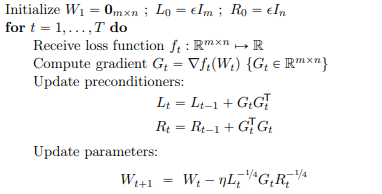

На каждой итерации из матриц $L_t$ размера $m$ x $m$ и $R_t$ размера $n$ x $n$, содержащих информацию о втором моменте из накопленных градиентов, формируются две предобусловленные матрицы, которые потом умножаются на градиентную матрицу слева направо соответственно. Каждая из предобусловленных матриц работает только с одним измерением градиента, сокращаясь по остальным, что позволяет неплохо ускорить процесс обучения. Объём пространства, который Shampoo использует в данном случае, составляет $O(m^2 + n^2)$ вместо $O(m^2 n^2)$ в сравнении с полноматричными методами. Более того, поскольку предобуславливание включает в себя обращение матрицы (и чаще всего спектральное разложение), объём вычислений для построения левого и правого предобуславливателей также сокращается с $O(m^3 n^3)$ до $O(m^3 + n^3)$.

Однако shampoo всё ещё требует больших вычислительных затрат, что особенно выделяется при работе с полносвязными и эмбэддинг слоями. Основная сложность возникает при вычислении p-х корней матриц $L_t^{-1/4}$ и $R_t^{-1/4}$, которые были реализованы с использованием спектрального разложения (SVD), что может занимать много времени. Поэтому для ускоренной работы Shampoo было разработано несколько улучшений:

- 1) Вычисление предобуславливателей раз в несколько сотен шагов. Поскольку в большинстве случаев структура функции потерь не изменяется существенно с каждым шагом, то и особого эффекта на снижение точности произойти не должно.

- 2) Использование эффективных итерационных методов для вычисления p-х корней вместо SVD, например, применение модификаций на основе метода Шура-Ньютона.

- 3) Использование одного из предобуславливателей $L_t^{-1/2p}$ или $R_t^{-1/2q}$, где $p, q > 0$.

- 4) Применение параллельного обучения на GPU.

Стоит отметить, что данные улучшения без проблем можно использовать для Shampoo в его общей форме, который применим к тензорам произвольной размерности. В фреймворках глубокого обучения реализована именно тензорная форма данного алгоритма, а его принцип работы выглядит следующим образом:

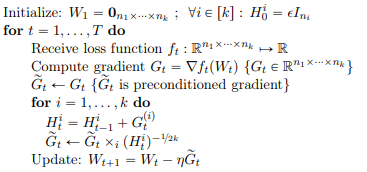

Проследив историю развития методов второго порядка, становится очевидно, что с появлением таких алгоритмов как Shampoo, их применение становится всё более привлекательным с практической точки зрения. На мой скромный взгляд, в будущем их популярность будет расти и они будут играть значимую роль не только в глубоком обучении, но и в других областях инженерии и науки.


## **Дополнительные источники**

Статьи:

- «Adam: A Method for Stochastic Optimization», Diederik P. Kingma, Jimmy Ba;

- «Decoupled Weight Decay Regularization», Ilya Loshchilov, Frank Hutter;

- «Incorporating Nesterov Momentum into Adam», Timothy Dozat;

- «Adaptive Methods for Nonconvex Optimization», Manzil Zaheer, Sashank J. Reddi, Devendra Sachan, Satyen Kale, Sanjiv Kumar;

- «Adan: Adaptive Nesterov Momentum Algorithm for Faster Optimizing Deep Models», Xingyu Xie, Pan Zhou, Huan Li, Zhouchen Lin, Shuicheng Yan;

- «On the Convergence of Adam and Beyond», Sashank J. Reddi, Satyen Kale, Sanjiv Kumar;

- «On the Convergence Proof of AMSGrad and a New Version», Tran Thi Phuong, Le Trieu Phong;

- «SGDR: Stochastic Gradient Descent with Warm Restarts», Ilya Loshchilov, Frank Hutter;

- «Optimization for deep learning: theory and algorithms», Ruoyu Sun;

- «Large Batch Training of Convolutional Networks», Yang You, Igor Gitman, Boris Ginsburg;

- «Large Batch Optimization for Deep Learning: Training BERT in 76 minutes», Yang You, Jing Li, Sashank Reddi, Jonathan Hseu, Sanjiv Kumar, Srinadh Bhojanapalli, Xiaodan Song, James Demmel, Kurt Keutzer, Cho-Jui Hsieh;

- «Proximal Algorithms», Neal Parikh, Stephen Boyd;

- «A Fast Iterative Shrinkage-Thresholding Algorithm», for Linear Inverse Problems, Amir Beck, and Marc Teboulle;

- «Improving Fast Iterative Shrinkage-Thresholding Algorithm: Faster, Smarter and Greedier», Jingwei Liang, Tao Luo, Carola-Bibiane Schönlieb;

- «Resurrecting the sigmoid in deep learning through dynamical isometry: theory and practice»,
Jeffrey Pennington, Samuel S. Schoenholz, Surya Ganguli;

- «Numerical Optimization», Jorge Nocedal, Stephen J. Wright;

- «A regularized limited-memory BFGS method for unconstrained minimization problems», Shinji SUGIMOTO and Nobuo YAMASHITA;

- «Shampoo: Preconditioned Stochastic Tensor Optimization», Vineet Gupta, Tomer Koren, Yoram Singer;

- «Scalable Second Order Optimization for Deep Learning», Rohan Anil, Vineet Gupta, Tomer Koren, Kevin Regan, Yoram Singer;

- «A Schur-Newton method for the matrix p'th root and its inverse», C.-H. Guo and N. J. Higham.


Видео:

- [пакетный градиентный спуск](https://www.youtube.com/watch?v=sDv4f4s2SB8);

- [стохастический и мини-пакетный градиентные спуски](https://www.youtube.com/watch?v=vMh0zPT0tLI);

- [оптимизации градиентного спуска](https://www.youtube.com/playlist?list=PLRznHSqUb86uuNA4eT96lk9_Y_CTwJlkK).

